<a href="https://colab.research.google.com/github/zmohaveri/IVT-ActiveLearning/blob/main/IVT_dispendix_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
import numpy as np
from collections import OrderedDict 
import pandas as pd
from shutil import copyfile
from string import ascii_uppercase as alphabets
import datetime as tm
from math import ceil
from itertools import combinations
import matplotlib.pyplot as plt

#Random samples

##Making random points

In [ ]:
def random_points_in_range(n,ranges):
  points = np.empty((n,len(ranges)))
  for i,element in enumerate(ranges):
    start=min(element[1],element[0])
    interval=abs(element[1]-element[0])
    rand_check = np.random.rand(n)
    randoms = ( rand_check*interval ) + start
    points[:,i] = randoms.T  
  return points

##adding pipetting action for each point to a CSV

In [ ]:
def add_line_to_file(line,file_path,mode='a'):
  with open(file_path,mode) as file:
    file.write('\n'+line)

def concentration_to_volume(sample_volume,concentration,stock_concentration):
  #c1.v1=c2.v2 => v1=c2.v2/c1
  return concentration*sample_volume/stock_concentration

def concentration_points_to_volumes(points,sample_volume,scanning_elements):
  max_volume=0
  volume_points=np.empty(points.shape)
  sums=np.zeros(points.shape[1:])
  for j,point in enumerate(points):
    volume_point=np.empty(points.shape[1:])
    for i,element in enumerate(scanning_elements):
      volume= concentration_to_volume(sample_volume,point[i],scanning_elements[element][1])
      sums[i] += volume
      source=scanning_elements[element][0]
      volume_point[i] = round(volume,2)
    max_volume= max( np.sum(volume_point) , max_volume)
    volume_points[j]=volume_point
  return volume_points,max_volume,sums

def add_dispense_to_file(volume_point,destination,fill_up_to,water_position,scanning_elements,file_path,extra=None):
  for i,element in enumerate(scanning_elements):
    #volume = concentration_to_volume(sample_volume,point[i],scanning_elements[element][1])
    source = extra[element][0] if (extra and (element in extra) ) else scanning_elements[element][0]
    add_line_to_file(f'{source},{destination},{volume_point[i]},{element}',file_path)
  water_volume = fill_up_to - np.sum(volume_point)
  water_volume = round(water_volume,2)
  add_line_to_file(f'{water_position},{destination},{water_volume},Water',file_path)
  return water_volume

def collection_to_csv_keys(collection):
  csv=''
  for element in collection:
    csv += f'{element},'
  return csv

def points_to_protocol(points,destination_wells,sample_volume,scanning_elements,water_positions,protocol_path,record_path,extra=None):
  add_line_to_file(f'destinations,{collection_to_csv_keys(scanning_elements)}',record_path,mode='a')
  volume_points, max_volume, sums = concentration_points_to_volumes(points,sample_volume,scanning_elements)
  max_volume = ceil(max_volume)
  sum_water = 0
  total_number_points=points.shape[0]
  number_of_waters = len(water_positions)
  #max_volume=10 #decided to determine by hand to keep mastermix volume at 10 for hand pipetting reasons
  for i,volum_point in enumerate(volume_points):
    extra=None if i>(total_number_points/2) else extra
    water_position = water_positions[i%number_of_waters]
    sum_water += add_dispense_to_file(volum_point,destination_wells[i],max_volume,water_position,scanning_elements,protocol_path,extra)
    add_line_to_file(f'{destination_wells[i]},{collection_to_csv_keys(points[i])}',record_path)
  return max_volume,sums,sum_water

def make_destination_wells(starting_number,finishing_number,starting_letter,finishing_letter):
  destination_wells=[]
  for letter in alphabets[alphabets.find(starting_letter):alphabets.find(finishing_letter)+1]:
    for number in range(starting_number,finishing_number+1):
      destination_wells.append(f'{letter}{number}')
  return destination_wells


In [ ]:
sample_volume=20

label=f'Iter2-{tm.datetime.now()}-'
path='/content/drive/MyDrive/Thesis/IVT/dispendix/iter2'
empty_path = '/content/drive/MyDrive/Thesis/IVT/dispendix/iter1/CSV_empty_header.csv'
protocol_path= path+f'/{label}protocol.csv'
record_path= path+f'/{label}concentrations.csv'
hand_Pipette_path= path+f'/{label}hand_Pipette.txt'
copyfile(empty_path,protocol_path)

scanning_elements = OrderedDict({'spermidine':('C5',250),'template':('D5',5000),'mgcl2':('E5',2000),'rntp':('G5',25)})
scanning_elements2 = OrderedDict({'spermidine':('C5',250),'template':('D5',5000),'mgcl2':('F5',2000),'rntp':('H5',25)})
extra1={'rntp':('A5',25)}
extra2={'rntp':('B5',25)}
water_positions = ['A4','B4','C4','D4','E4','F4','G4','H4']
random_samples = random_points_in_range(96,[(0,5),(0,200),(0,200),(0,5)])
destination_wells1 = make_destination_wells(13,24,'A','H')
destination_wells2 = make_destination_wells(13,24,'I','P')#rep2
points_to_protocol(random_samples,destination_wells1,sample_volume,scanning_elements,water_positions,protocol_path,record_path,extra1)
max_volume,sums,sum_water=points_to_protocol(random_samples,destination_wells2,sample_volume,scanning_elements2,water_positions,protocol_path,record_path,extra2)
print(max_volume)
print(scanning_elements.keys(),sums*2)
print(sum_water*2)
print('rntp each',sums[-1]*2/4)

7
odict_keys(['spermidine', 'template', 'mgcl2', 'rntp']) [ 38.4258045   76.71752279 176.58278896 371.91641328]
680.2600000000002
rntp each 92.97910332055395


In [ ]:
print(668/8)
print(372/4)

83.5
93.0


iter1
6
odict_keys(['spermidine', 'template', 'mgcl2', 'rntp']) [ 80.87963055  65.15810612 129.06866217 389.93290955]
487.0800000000002
rntp each 97.48322738827794

mastermix composition

In [ ]:
mastermix_in_sample = {'dfhbi':40,'tris_dtt':1,'t7':100}
mastermix_stock = {'dfhbi':4000,'tris_dtt':10,'t7':12311}
total_vol = 0
number_of_wells=((96*2)+8)/2
print(number_of_wells,'2X')
add_line_to_file(f'{number_of_wells}-2X',hand_Pipette_path,mode='w')
for element in mastermix_in_sample:
  volume = concentration_to_volume(sample_volume,mastermix_in_sample[element],mastermix_stock[element])
  total_vol += volume
  print(f'{element}: {volume*number_of_wells}')
  add_line_to_file(f'{element}: {volume*number_of_wells}',hand_Pipette_path,mode='w')
print(total_vol*number_of_wells)
mastermix_vol= sample_volume - max_volume
water_volume= mastermix_vol - total_vol
print(f'Water: {water_volume*number_of_wells}')
add_line_to_file(f'Water: {water_volume*number_of_wells}',hand_Pipette_path,mode='w')
print('mastermix to each well:',mastermix_vol)
add_line_to_file(f'mastermix to each well:{mastermix_vol}',hand_Pipette_path,mode='w')
print(f'mastermix in each strip: {mastermix_vol*number_of_wells/8}')

100.0 2X
dfhbi: 20.0
tris_dtt: 200.0
t7: 16.2456339858663
236.24563398586633
Water: 1063.7543660141337
mastermix to each well: 13
mastermix in each strip: 162.5


In [43]:
print(162.5*8/2)
print(1063.7543660141337/2)
print(13*96/8)

650.0
531.8771830070668
156.0


#distribution

In [ ]:
#get info of the executed experiment
executed_path='/content/drive/MyDrive/Thesis/IVT/dispendix/iter1/2020-11-10-2020-11-12 21:50:17.578393-concentrations.csv'
executed_concentrations=pd.read_csv(executed_path)
executed_concentrations.drop(columns=['Unnamed: 5','destinations'],inplace=True)
executed_concentrations=executed_concentrations[:96]
concentrations_columns=list(executed_concentrations)
scanning_concentrations={}

for column in concentrations_columns:
  scanning_concentrations[column] = np.array(executed_concentrations[column])
  scanning_concentrations[column]=scanning_concentrations[column].astype(float,copy=False)

executed_concentrations

,spermidine,template,mgcl2,rntp
0,7.1515834929378155,100.02359844829762,65.87337647424803,2.598990683143069
1,9.891616974582526,154.21956804045206,108.0123561522101,3.5129162575956836
2,2.5112153494305156,150.71164285404157,42.05022263924605,1.3685355152941048
3,8.666945987414952,69.28507970301177,19.58230592576924,4.305927040954567
4,2.847339049891594,58.39523933088221,56.99706065532879,0.6610313691471165
...,...,...,...,...
91,0.8538633082188563,13.329800681349276,69.74483621265544,2.116488177019563
92,5.687597996596757,16.214081880903368,39.95641774493461,1.1923896816308632
93,4.398608607453561,89.12542428291002,69.4890438218786,4.935712829814298
94,2.6879626246361865,189.0667649466583,11.2983951559126,1.481622861549886


In [ ]:

def plot_3d_distribution (xs,ys,zs,name,xlabel='x',ylabel='y',zlabel='z'):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(xs, ys, zs, zdir='z')
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_zlabel(zlabel)
  plt.show()
  plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

def plot_2d_distribution (x,y,name,xlabel='x',ylabel='y'):
  #fig, ax = plt.subplots(dimensions[0],dimensions[1],figsize=100)
  fig, ax = plt.subplots()
  plt.scatter(x,y,alpha=0.2)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  plt.show()
  #plt.savefig(saving_path(f'distribution-{name}','jpg'))
  plt.clf()

('spermidine', 'template')


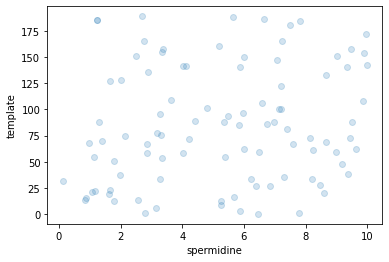

('spermidine', 'mgcl2')


<Figure size 432x288 with 0 Axes>

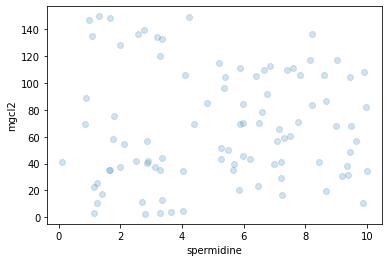

('spermidine', 'rntp')


<Figure size 432x288 with 0 Axes>

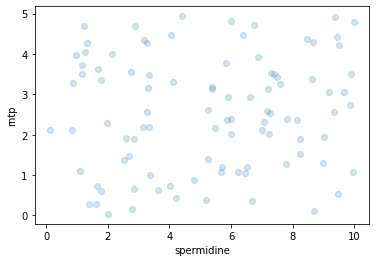

('template', 'mgcl2')


<Figure size 432x288 with 0 Axes>

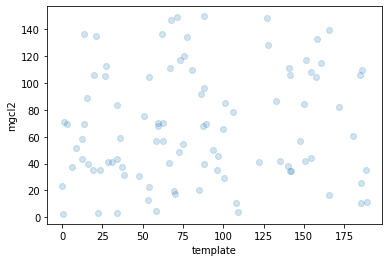

('template', 'rntp')


<Figure size 432x288 with 0 Axes>

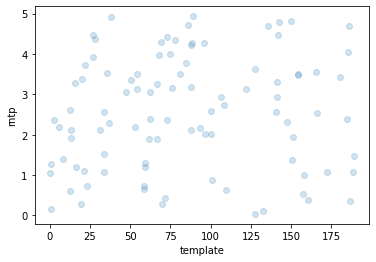

('mgcl2', 'rntp')


<Figure size 432x288 with 0 Axes>

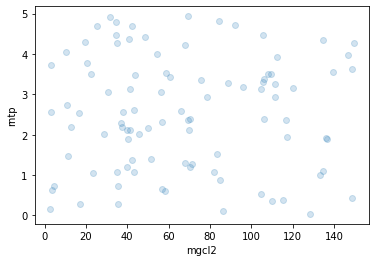

<Figure size 432x288 with 0 Axes>

In [ ]:
comb=combinations(concentrations_columns,2)
for names in comb:
  print(names)
  xlabel,ylabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  plot_2d_distribution(xs,ys,str(names),xlabel,ylabel)

In [ ]:
'''
comb=combinations(concentrations_columns,3)
for names in comb:
  print(names)
  xlabel,ylabel,zlabel=names
  xs=scanning_concentrations[xlabel]
  ys=scanning_concentrations[ylabel]
  zs=scanning_concentrations[zlabel]
  print(xs.shape,ys.shape,zs.shape)
  plot_3d_distribution(xs,ys,zs,str(names),xlabel,ylabel,zlabel)
  '''
x=1